In [494]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [495]:
digits_data = datasets.load_digits()

In [496]:
X_ , Y_ = digits_data['data'],digits_data['target']

In [497]:
digits_data.data[0].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

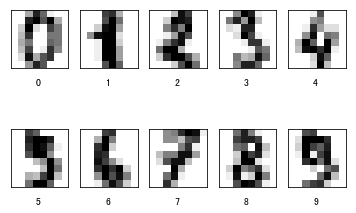

In [498]:
for i in range(1,11):
    # plt.subplot(nrows,ncols,index)
    plt.subplot(2,5,i)
    plt.imshow(digits_data.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits_data.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [499]:
# 将数据集划分成训练集和测试集 为了进行交叉验证
X_train,X_test,y_train,y_test = train_test_split(digits_data.data,digits_data.target,test_size=0.25)

In [500]:
from collections import Counter

In [501]:
# 查看Y_样本的分类情况 
Counter(Y_)

Counter({0: 178,
         1: 182,
         2: 177,
         3: 183,
         4: 181,
         5: 182,
         6: 181,
         7: 179,
         8: 174,
         9: 180})

In [502]:
# 将标签Y 转化成one-hot格式
def convert_to_onehot(Y, C):
    
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [503]:
y_train_onehot = convert_to_onehot(y_train,10)
y_test_onehot = convert_to_onehot(y_test,10)

### 1.定义激活函数

In [504]:
def softmax(Z):

    Z_shift = Z - np.max(Z, axis = 1).reshape(-1,1)
    A = np.exp(Z_shift)/ np.sum(np.exp(Z_shift), axis=1).reshape(-1,1)
    
    cache = Z_shift
    
    return A, cache

In [505]:
def relu(Z):

    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

### 2.初始化参数

In [506]:
# Random innitialize the parameters

def initialize_parameters(n_x,n_h,n_y):
    
    W1 = np.random.randn(n_x,n_h)*0.01
    b1 = np.zeros((1,n_h))
    W2 = np.random.randn(n_h,n_y)*0.01
    b2 = np.zeros((1,n_y))
    
    parameter = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }
    
    return parameter 

In [507]:
parameter = initialize_parameters(64,32,10)

In [508]:
W1 = parameter['W1']
b1 = parameter['b1']
W2 = parameter['W2']
b2 = parameter['b2']

In [509]:
print(W1.shape)
print(b1.shape)
print(W2.shape)
print(b2.shape)

(64, 32)
(1, 32)
(32, 10)
(1, 10)


### 3.向前传播

In [512]:
def linear_forward(A, W, b):
    
    Z = np.dot(A,W) + b
    
    cache = (A, W, b)
    
    return Z, cache

### 4.cost function

In [513]:
def compute_cost(AL, Y):
    m = Y.shape[0]
    cost = -(np.sum(Y * np.log(AL))) / float(m)
    #cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

### 5.向后传播

In [514]:
def softmax_backward(Y, cache):
    Z = cache  #注意cache中的Z实际是Z_shift
    
    s = np.exp(Z)/ np.sum(np.exp(Z), axis=1).reshape(-1,1)
    dZ = s - Y
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [515]:
def linear_backward(dZ, inputs):
    A_prev, W, b = inputs
    m = A_prev.shape[0]

    dW = np.dot(A_prev.T,dZ) / float(m)
    db = np.sum(dZ, axis=0, keepdims=True) / float(m)
    dA_prev = np.dot(dZ,W.T)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [516]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### 6.梯度下降算法

In [520]:
def get_parameter_gradient(X,Y,W1,b1,W2,b2):
    
    m = X.shape[0]
    # 隐藏层第一层线性组合
    l1 , cache_l1 = linear_forward(X,W1,b1)
    # 隐藏层第一层激活函数 relu
    r1 , cache_r1 = relu(l1)
    # 隐藏层第二层线性组合
    l2 , cache_l2 = linear_forward(r1,W2,b2)
    # 隐藏层第二层激活函数 softmax
    s1 , cache_s1 = softmax(l2)
    # 计算交叉熵损失函数
    cost = compute_cost(s1,Y)
    
    # 然后反向传播 得到dW1,db1,dW2,db2
    ds = softmax_backward(Y , cache_s1)
    dl2 , dW2 , db2 = linear_backward(ds , cache_l2)
    dr = relu_backward(dl2 , cache_r1)
    dx , dW1 , db1 = linear_backward(dr , cache_l1)
    
    result = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    
    return result,cost

In [521]:
get_parameter_gradient(X_train,y_train_onehot,W1,b1,W2,b2)

({'dW1': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.01548932e-04, -9.36525733e-04, -1.35541975e-04, ...,
          -7.12316821e-04, -2.15438004e-03, -1.08788202e-03],
         [ 7.69013446e-03, -7.82981375e-03, -6.58178117e-03, ...,
          -4.00205566e-03, -2.06484491e-02, -7.94011150e-03],
         ...,
         [ 6.63766297e-03, -9.47113595e-03,  9.29994200e-04, ...,
          -2.19511749e-03,  3.92967616e-03, -7.08106752e-03],
         [ 5.58611469e-03, -3.02959594e-03,  4.48089077e-04, ...,
          -9.19401099e-04,  3.13294794e-03, -4.39599984e-03],
         [ 6.33395659e-04,  3.46722509e-04,  1.18818476e-03, ...,
          -2.28603033e-05,  1.15023303e-04, -1.08497964e-03]]),
  'db1': array([[-2.19466268e-05, -5.21478182e-04, -7.91986365e-04,
          -3.26780221e-04,  2.64173129e-05, -1.25624178e-04,
          -3.04409947e-04, -6.41384996e-04,  1.42399750e-04,
          -1.922851

In [522]:
def gradient_descent(X,Y,W1=W1,b1=b1,W2=W2,b2=b2,num_iterations=10000,learning_rate=0.01,print_cost=False):
    
    costs = []
    
    for i in range(num_iterations):
        
        result,cost = get_parameter_gradient(X,Y,W1,b1,W2,b2)
        
        dW1 = result['dW1']
        db1 = result['db1']
        dW2 = result['dW2']
        db2 = result['db2']
        
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    params = {
        "W1" : W1,
        "b1" : b1,
        "W2" : W2,
        "b2" : b2
    }
    
    return params,costs

In [523]:
params,costs = gradient_descent(X_train,y_train_onehot,print_cost=True)

Cost after iteration 0: 2.297060
Cost after iteration 100: 1.026689
Cost after iteration 200: 0.365782
Cost after iteration 300: 0.227608
Cost after iteration 400: 0.167878
Cost after iteration 500: 0.134355
Cost after iteration 600: 0.112720
Cost after iteration 700: 0.097477
Cost after iteration 800: 0.086120
Cost after iteration 900: 0.077179
Cost after iteration 1000: 0.069894
Cost after iteration 1100: 0.063801
Cost after iteration 1200: 0.058626
Cost after iteration 1300: 0.054152
Cost after iteration 1400: 0.050260
Cost after iteration 1500: 0.046824
Cost after iteration 1600: 0.043780
Cost after iteration 1700: 0.041065
Cost after iteration 1800: 0.038632
Cost after iteration 1900: 0.036438
Cost after iteration 2000: 0.034449
Cost after iteration 2100: 0.032646
Cost after iteration 2200: 0.031001
Cost after iteration 2300: 0.029492
Cost after iteration 2400: 0.028103
Cost after iteration 2500: 0.026820
Cost after iteration 2600: 0.025631
Cost after iteration 2700: 0.024526
Cost

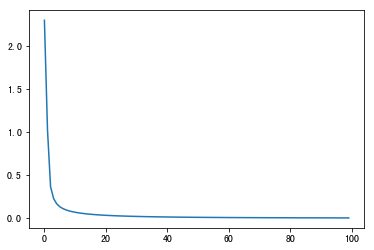

In [524]:
plt.plot(list(range(100)),costs)

In [525]:
best_W1 = params['W1']
best_b1 = params['b1']
best_W2 = params['W2']
best_b2 = params['b2']

In [526]:
def predict(X,best_W1=best_W1,best_b1=best_b1,best_W2=best_W2,best_b2=best_b2):
    
    m = X.shape[0]
    l1 , cache_l1 = linear_forward(X,best_W1,best_b1)
    r1 , cache_r1 = relu(l1)
    l2 , cache_l2 = linear_forward(r1,best_W2,best_b2)
    s1 , cache_s1 = softmax(l2)
    
    predict_y_prob = s1
    
    y_predict = np.argmax(predict_y_prob,axis=1)
    
    return y_predict

In [527]:
predict_y = predict(X_test)

In [528]:
m = y_test.shape[0]

In [529]:
print("Accuracy: "  + str(np.sum(predict_y == y_test) / float(m)))

Accuracy: 0.9644444444444444
